## Stochastic Volatility: Likelihood Inference and Comparison with ARCH Models
### Financial Econometrics 20-21 Fall II Final Presentation
#### This is part of the final project reproduced result from Group 2.
Jian Zhou,1801212818\
Chi Zhou,1901212684\
Yuting Fang,1901212576

This notebook reproduce partial results of the paper(section 2 and section 3) which is estimating the basic univariate stochastic volatility model with Bayesian methods via Markov chain monte carlo (MCMC) methods.

Citation: https://github.com/ChadFulton/tsa-notebooks/blob/master/stochastic_volatility_mcmc.ipynb

## 1.Introduction

In [3]:
%matplotlib inline
from __future__ import division

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=5)

from scipy.stats import norm, invgamma
from scipy.special import logsumexp

import sv

A canonical univariate stochastic volatility model is:

$$
\begin{align}
y_t & = \beta 
e^{h_t / 2} \varepsilon_t & \varepsilon_t \sim N(0, 1)\\
h_{t+1} & = \mu + \phi(h_t - \mu) + \sigma_\eta \eta_t \qquad & \eta_t \sim N(0, 1) \\
h_1 & \sim N(\mu, \sigma_\eta^2 / (1 - \phi^2))
\end{align}
$$

Here, $y_t$ usually represents the mean-corrected return of some asset and $h_t$ is log-volatility. Since $\beta$ is easier to interpret, we can give results in terms of $\beta = \exp(\mu / 2)$. The parameter $\beta$ plays the role of the constant scaling factor and can be thought of as the model instantaneous volatility.

By taking squares and logs of each side of the first equation, above, we get the following observation equation (here we have set $\beta = 1$):

$$y_t^* = h_t + z_t$$(offset mixture representation)

where $y_t^* = \log (y_t^2 + c)$, $z_t = \log \varepsilon_t^2$, and so $E[z_t] = 1.27036$ and $\text{Var}(z_t) = 4.93$ and $c$ is an offset to prevent numerical issues when $y_t$ is close to zero, set by KSC to $0.001$. Along with the transition equation for $h_t$, above, this forms a non-Gaussian state space model.

## 2. Illustration a Quasi-likelihood Estimation for Exchange Rate Dataset

### 2.1 Import the dataset

For the empirical illustration in this notebook, we will follow the dataset in modeling the U.K. Sterling / U.S. Dollar exchange rate between October 1, 1981 and June 28, 1985. 

*** No CODEPAGE record, no encoding_override: will use 'ascii'


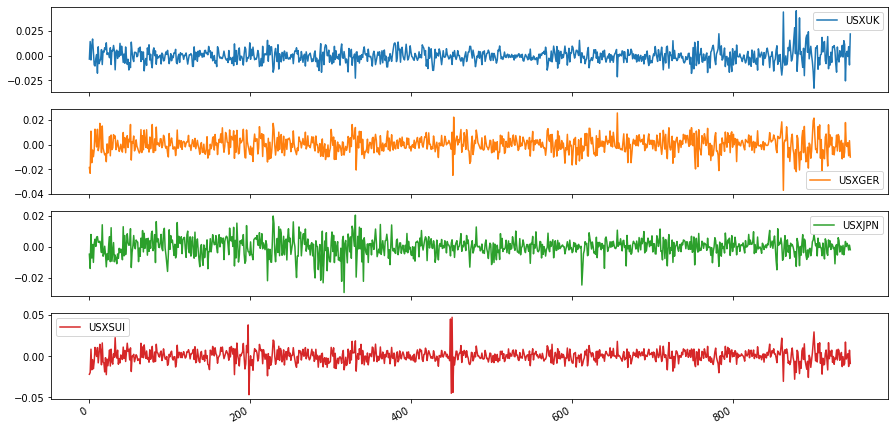

In [4]:
#plot the dataset
ex = pd.read_excel('xrates.xls')
dta = np.log(ex).diff().iloc[1:]
dta.plot(subplots=True, figsize=(15, 8));

In [5]:
#show the first 5 data
endog = (dta['USXUK'] - dta['USXUK'].mean()) * 100
print(endog.head(5))

1   -0.320232
2    1.460709
3   -0.408640
4    1.060950
5    1.712879
Name: USXUK, dtype: float64


### 2.2 Quasi-likelihood estimation

"Quasi-likelihood method" is that the model is approximated by replacing $\log \varepsilon_t^2$ with a Gaussian random variable of the same mean and variance.

In [6]:
mod_QLSV = sv.QLSV(endog)
res_QLSV = mod_QLSV.fit()

### 2.3 Results

In [7]:
print(res_QLSV.summary())

                           Statespace Model Results                           
Dep. Variable:                  USXUK   No. Observations:                  945
Model:                           QLSV   Log Likelihood               -1973.517
Date:                Tue, 12 Jan 2021   AIC                           3953.034
Time:                        23:07:31   BIC                           3967.588
Sample:                             0   HQIC                          3958.581
                                - 945                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
phi            0.9909      0.010     96.107      0.000       0.971       1.011
sigma2_eta     0.0059      0.006      0.981      0.327      -0.006       0.018
mu            -0.7082      0.331     -2.143      0.0

## 3. Improved MCMC Algorithms 
### 3.1 Bayesian estimation

An alternative method for estimating this model is using Bayesian techniques which is called offset mixture of normals distribution to accurately approximate the exact likelihood. \
This approximation helps in the production of an efficient Monte Carlo procedure that to sample all the log-volatilities at once.

In detail, we can transform the model for $y_t$ into a linear model in $\log y_t^2$, we have:

$$
\begin{align}
\log y_t^2 & = h_t + \log \varepsilon_t^2\\
h_{t+1} & = \mu + \phi(h_t - \mu) + \sigma_\eta \eta_t \\
h_1 & \sim N(\mu, \sigma_\eta^2 / (1 - \phi^2))
\end{align}
$$

here, $E(\log \varepsilon_t^2) \approx -1.27$ and $Var(\log \varepsilon_t^2) = \pi^2 / 2$.

$$z_t | s_t = i \sim N(m_i - 1.27036, v_i^2)$$

where $s_t$ is an indicator random variable defined so that $P(s_t = i) = q_i, i = 1, \dots, K$ where $K$ is the number of mixture components.

### 3.2 Priors

To compute the model, we need to specify a prior distribution for the parameters. 

#### Prior for $\sigma_\eta^2$

We consider the conjugate prior:

$$\sigma_\eta^2 | \phi, \mu \sim IG(\sigma_r / s, S_\sigma / 2)$$

where we follow them setting $\sigma_r = 5$ and $S_\sigma = 0.01 \times \sigma_r = 0.05$.

#### Prior for $\phi$

Defining $\phi^* = (\phi + 1) / 2$, we specify a prior on $\phi^*$:

$$\phi^* \sim Beta(\phi^{(1)}, \phi^{(2)})$$

this prior has support over $(-1, 1)$, enforcing stationarity of the stochastic volatility process.

Setting $\phi^{(1)} = 20$ and $\phi^{(2)} = 1.5$ implies that $E[\phi] = 0.86$.

Finally:

$$\pi(\phi) \propto \left [ \frac{(1 + \phi)}{2} \right ]^{\phi^{(1)} - 1} \left [ \frac{(1 - \phi)}{2} \right ]^{\phi^{(2)} - 1} $$

#### Prior for $\mu$

a diffuse prior on $\mu$ (or alternatively a slightly informative prior like $\mu \sim N(0, 10)$).

### 3.3 Posterior
Sampling from the conditional posteriors

#### Sampling $\sigma_\eta^2$

The conditional posterior distribution is:

$$\sigma_\eta^2 | y, h, \phi, \mu \sim IG \left ( \frac{n + \sigma_r}{2},
\frac{S_\sigma + (h_1 - \mu)^2(1 - \phi^2) + \sum_{i=1}^{n-1} [(h_{t+1} - \mu) - \phi(h_t-\mu)]^2}{2} \right )$$

In [8]:
def draw_posterior_sigma2(model, states, phi, mu, prior_params=(5, 0.05)):
    sigma_r, S_sigma = prior_params

    v1 = sigma_r + model.nobs
    tmp1 = (states[0, 0] - mu)**2 * (1 - phi**2)
    tmp = np.sum(((states[0, 1:] - mu) - phi * (states[0, :-1] - mu))**2)
    delta1 = S_sigma + tmp1 + tmp

    return invgamma.rvs(v1, scale=delta1)

#### Sampling $\phi$

We can apply a Metropolis step: generating a proposal value $\phi^*$ from $N(\hat \phi, V_\theta)$ and accepting the proposal with probability

$$\exp(g(\phi^*) - g(\phi^{(i-1)}))$$

where:

$$g(\phi) = \log \pi(\phi) - \frac{(h_1 - \mu)^2 (1 - \phi^2)}{2 \sigma_\eta^2} + \frac{1}{2} \log (1 - \phi^2)$$

In [9]:
def g(phi, states, mu, sigma2, prior_params=(20, 1.5)):
    phi_1, phi_2 = prior_params

    # Prior distribution gives zero weight to non-stationary processes
    if np.abs(phi) >= 1:
        return -np.inf

    prior = ((1 + phi) / 2)**(phi_1 - 1) * ((1 - phi) / 2)**(phi_2 - 1)

    tmp1 = (states[0, 0] - mu)**2 * (1 - phi**2) / 2 * sigma2
    tmp2 = 0.5 * np.log(1 - phi**2)

    return np.log(prior) - tmp1 + tmp2

def draw_posterior_phi(model, states, phi, mu, sigma2, prior_params=(20, 1.5)):
    tmp1 = np.sum((states[0, 1:] - mu) * (states[0, :-1] - mu))
    tmp2 = np.sum((states[0, :-1] - mu)**2)
    phi_hat = tmp1 / tmp2
    V_phi = sigma2 / tmp2

    proposal = norm.rvs(phi_hat, scale=V_phi**0.5)
    g_proposal = g(proposal, states, mu, sigma2, prior_params)
    g_previous = g(phi, states, mu, sigma2, prior_params)
    acceptance_probability = np.exp(g_proposal - g_previous)

    return proposal if acceptance_probability > np.random.uniform() else phi

#### Sampling $\mu$

The conditional posterior distribution is:

$$\mu | y, h, \phi, \sigma_\eta^2 \sim N (\hat \mu, \sigma_\mu^2)$$

where:

$$
\begin{aligned}
\hat \mu & = \sigma_\mu^2 \left [ \frac{(1 - \phi^2)}{\sigma_\eta^2} h_1 + \frac{(1 - \phi)}{\sigma_\eta^2} \sum_{t=1}^{n-1} (h_{t+1} - \phi h_t) \right ] \\
\sigma_\mu^2 & = \sigma_\eta^2 \left [ (n - 1)(1 - \phi)^2 + (1 - \phi^2) \right ]^{-1}
\end{aligned}
$$

In [10]:
def draw_posterior_mu(model, states, phi, sigma2):
    sigma2_mu = sigma2 / ((model.nobs - 1) * (1 - phi)**2 + (1 - phi**2))

    tmp1 = ((1 - phi**2) / sigma2) * states[0, 0]
    tmp = ((1 - phi) / sigma2) * np.sum(states[0, 1:] - phi * states[0, :-1])
    mu_hat = sigma2_mu * (tmp1 + tmp)

    return norm.rvs(loc=mu_hat, scale=sigma2_mu**0.5)

In [11]:
def mixing_posterior(mod, states):
    resid = mod.endog[:, 0] - states[0]

    # Construct the means (nobs x 7), variances (7,), prior probabilities (7,)
    means = ksc_params[None, :, 1] - 1.27036
    variances = ksc_params[:, 2]
    prior_probabilities = ksc_params[:, 0]

    # Make dimensions compatible for broadcasting
    resid = np.repeat(resid[:, None], len(variances), axis=-1)
    variances = np.repeat(variances[None, :], mod.nobs, axis=0)
    prior_probabilities = np.repeat(prior_probabilities[None, :], mod.nobs,
                                    axis=0)

    # Compute loglikelihood (nobs x 7)
    loglikelihoods = -0.5 * ((resid - means)**2 / variances +
                             np.log(2 * np.pi * variances))

    # Get (values proportional to) the (log of the) posterior (nobs x 7)
    posterior_kernel = loglikelihoods + np.log(prior_probabilities)

    # Normalize to get the actual posterior probabilities
    tmp = logsumexp(posterior_kernel, axis=1)
    posterior_probabilities = np.exp(posterior_kernel - tmp[:, None])

    return posterior_probabilities

def draw_mixing(mod, states):
    posterior_probabilities = mixing_posterior(mod, states)

    # Draw from the posterior
    variates = np.random.uniform(size=mod.nobs)
    tmp = np.cumsum(posterior_probabilities, axis=1) > variates[:, None]
    sample = np.argmax(tmp, axis=1)

    return sample

### 3.4 MCMC

Below we perform 10,000 iterations to sample from the posterior. When presenting results, below, we will drop the first 5,000 iterations as the burn-in period, and of the remaining 5,000 iterations we will save only every tenth iteration. Results will then be computed from the remaining 500 iterations.

In [12]:
# q_i, m_i, v_i^2
ksc_params = np.array([[0.04395, 2.77786,   0.16735],
                       [0.24566, 1.79518,   0.34023],
                       [0.34001, 0.61942,  0.64009],
                       [0.25750, -1.08819,  1.26261],
                       [0.10556, -3.97281,  2.61369],
                       [0.00002, -8.56686,  5.17950],
                       [0.00730, -10.12999, 5.79596]])

class TVLLDT(sm.tsa.statespace.MLEModel):
    """
    Time-varying local linear deterministic trend
    """
    def __init__(self, endog, offset=0.001):
        # Convert to log squares, with offset
        endog = np.log(endog**2 + offset)

        # Initialize base model
        super(TVLLDT, self).__init__(endog, k_states=1, k_posdef=1,
                                     initialization='stationary')

        # Setup time-varying arrays for observation equation
        self['obs_intercept'] = np.zeros((1, self.nobs))
        self['obs_cov'] = np.zeros((1, 1, self.nobs))

        # Setup fixed components of state space matrices
        self['design', 0, 0] = 1
        self['selection', 0, 0] = 1

    def update_mixing(self, indicators):
        # z_t | s_t ~ N(m_i - 1.27036, v_i^2)
        # See equation (10), p. 371
        self['obs_intercept', 0] = ksc_params[indicators, 1] - 1.27036
        self['obs_cov', 0, 0] = ksc_params[indicators, 2]

    def update(self, params, **kwargs):
        params = super(TVLLDT, self).update(params, **kwargs)

        self['state_intercept', 0, 0] = params[0] * (1 - params[1])
        self['transition', 0, 0] = params[1]
        self['state_cov', 0, 0] = params[2]

In [13]:
np.random.seed(1234)

# Setup the model and simulation smoother
mod = TVLLDT(endog)
mod.set_smoother_output(0, smoother_state=True)
sim = mod.simulation_smoother()

# Simulation parameters
n_iterations = 10000
burn = 5000
thin = 10

# Storage for traces
trace_smoothed = np.zeros((n_iterations + 1, mod.nobs))
trace_states = np.zeros((n_iterations + 1, mod.nobs))
trace_mixing = np.zeros((n_iterations + 1, mod.nobs), int)
trace_mu = np.zeros((n_iterations + 1, 1))
trace_phi = np.zeros((n_iterations + 1, 1))
trace_sigma2 = np.zeros((n_iterations + 1, 1))

# Initial values (p. 367)
trace_mixing[0] = 0
trace_mu[0] = 0
trace_phi[0] = 0.95
trace_sigma2[0] = 0.5

# Iterations
for s in range(1, n_iterations + 1):
    # Update the parameters of the model
    mod.update_mixing(trace_mixing[s-1])
    params = np.r_[trace_mu[s-1], trace_phi[s-1], trace_sigma2[s-1]]
    mod.update(params, transformed=True)
    
    # Simulation smoothing
    sim.simulate()
    states = sim.simulated_state
    trace_states[s] = states[0]

    # Draw mixing indicators
    trace_mixing[s] = draw_mixing(mod, states)
    
    # Draw parameters
    trace_phi[s] = draw_posterior_phi(mod, states, trace_phi[s-1], trace_mu[s-1], trace_sigma2[s-1])
    trace_sigma2[s] = draw_posterior_sigma2(mod, states, trace_phi[s-1], trace_mu[s-1])
    trace_mu[s] = draw_posterior_mu(mod, states, trace_phi[s-1], trace_sigma2[s-1])

### 3.5 Results

#### Compare the  parameters of MCMC Model with Quasi-likelihood Method Model

In [14]:
# Means of parameters
mean_phi = np.mean(trace_phi[burn::thin])
mean_sigma = np.mean(trace_sigma2[burn::thin]**0.5)
mean_beta = np.mean(np.exp(trace_mu[burn::thin] / 2))

print('Replication of Table 5: means of posterior draws from MCMC')
print('  phi | y        = %.5f (0.97779)' % mean_phi)
print('  sigma | y      = %.5f (0.15850)' % mean_sigma)
print('  beta | y       = %.5f (0.64733)' % mean_beta)
print('')
print('QMLE estimates')
print('  phi            = %.5f' % res_QLSV.params[0])
print('  sigma          = %.5f' % res_QLSV.params[1]**0.5)
print('  beta           = %.5f' % np.exp(res_QLSV.params[2] / 2))

Replication of Table 5: means of posterior draws from MCMC
  phi | y        = 0.97600 (0.97779)
  sigma | y      = 0.15947 (0.15850)
  beta | y       = 0.65292 (0.64733)

QMLE estimates
  phi            = 0.99091
  sigma          = 0.07663
  beta           = 0.70181


#### Plot the Estimated Stochastic Volatility
Since the parameter $\sigma_\eta$ controls the variance of the underlying stochastic volatility process, underestimation will dampen changes in the volatility process over the sample. This is shown in the below graph.

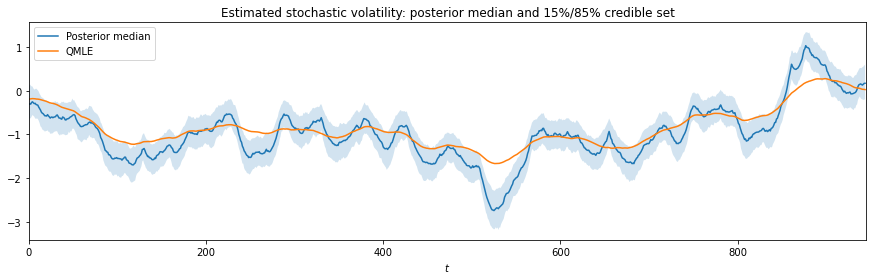

In [15]:
fig, ax = plt.subplots(figsize=(15, 4))

posterior_states = np.percentile(trace_states[burn::thin], (15, 50, 85), axis=0)

ax.plot(posterior_states[1], label='Posterior median')
ax.fill_between(np.arange(mod.nobs), posterior_states[0], posterior_states[2], alpha=0.2)
ax.plot(res_QLSV.smoothed_state[0], label='QMLE')
ax.set(title='Estimated stochastic volatility: posterior median and 15%/85% credible set',
       xlabel=r'$t$', xlim=(0, len(endog)))
ax.legend();

#### Plot the distribution of parameters in MCMC Estimation

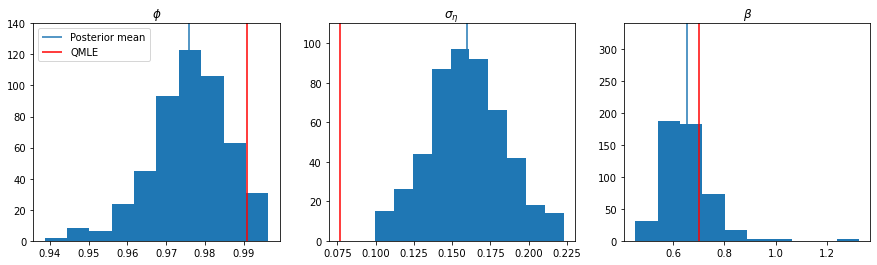

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(trace_phi[burn::thin])
ylim = (0, 140)
axes[0].vlines(mean_phi, ylim[0], ylim[1], label='Posterior mean')
axes[0].vlines(res_QLSV.params[0], ylim[0], ylim[1], color='r', label='QMLE')
axes[0].set(title=r'$\phi$', ylim=ylim)
axes[0].legend(loc='upper left')

axes[1].hist(trace_sigma2[burn::thin]**0.5)
ylim = (0, 110)
axes[1].vlines(mean_sigma, ylim[0], ylim[1], label='Posterior mean')
axes[1].vlines(res_QLSV.params[1]**0.5, ylim[0], ylim[1], color='r', label='QMLE')
axes[1].set(title=r'$\sigma_\eta$', ylim=ylim)

axes[2].hist(np.exp(trace_mu[burn::thin] / 2))
ylim = (0, 340)
axes[2].vlines(mean_beta, ylim[0], ylim[1], label='Posterior mean')
axes[2].vlines(np.exp(res_QLSV.params[2] / 2), ylim[0], ylim[1], color='r', label='QMLE')
axes[2].set(title=r'$\beta$', ylim=ylim);

#把ht

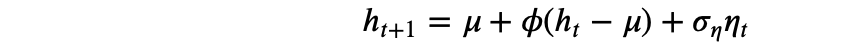